#Dependencies

In [ ]:
!pip install keras_self_attention

#Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
from PIL import Image
from mpl_toolkits import mplot3d
from tensorflow import keras
from keras_self_attention import SeqSelfAttention as Attention
from tensorflow.keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras import applications
from keras.layers import InputLayer, Dropout, Bidirectional, Masking, LSTM, Dense, Activation, Flatten, Input, concatenate, Embedding
from keras import backend as K 
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras.models import Model, Sequential
from tensorflow.python.client import device_lib

#Visualization functions

In [81]:
def rotate(matrix, degree):

  radian = (degree * np.pi) / 180

  rx = np.array([[1, 0, 0], 
                 [0, np.cos(radian), -np.sin(radian)],
                 [0, np.sin(radian), np.cos(radian)]])
    
  return np.dot(rx, matrix)

In [82]:
def savingRule(num):

    alphabets = 'abcdefghijklmnopqrstuvwxyz'
    numbers = '0123456789'
    len_up = len(alphabets) * len(numbers)
    len_down = len(numbers)

    lft1, num = num // len_up, num % len_up

    lft2, lft3 = num // len_down, num % len_down

    name = alphabets[lft1] + alphabets[lft2] + numbers[lft3]

    return name

In [83]:
def makeGIF(name, duration):

  fp_in = "*_plot.png"
  fp_out = name + ".gif"

  img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]

  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=duration, loop=0)

In [84]:
def visualize(file_number=0, verbose=True):

  for frn in range(bd_test.shape[1]):

    body = bd_test[file_number, frn, :].reshape(5, 3).T
    right_hand = rh_test[file_number, frn, :].reshape(6, 3).T
    left_hand = lh_test[file_number, frn, :].reshape(6, 3).T
    right_foot = rf_test[file_number, frn, :].reshape(4, 3).T
    left_foot = lf_test[file_number, frn, :].reshape(4, 3).T

    degree = 105

    body = rotate(body, degree).T
    right_hand = rotate(right_hand, degree).T
    left_hand = rotate(left_hand, degree).T
    right_foot = rotate(right_foot, degree).T
    left_foot = rotate(left_foot, degree).T

    x1, y1, z1 = body[:, 0], body[:, 1], body[:, 2]
    x2, y2, z2 = right_hand[:, 0], right_hand[:, 1], right_hand[:, 2]
    x3, y3, z3 = left_hand[:, 0], left_hand[:, 1], left_hand[:, 2]
    x4, y4, z4 = right_foot[:, 0], right_foot[:, 1], right_foot[:, 2]
    x5, y5, z5 = left_foot[:, 0], left_foot[:, 1], left_foot[:, 2]

    if (body == np.zeros(body.shape)).all():

      break
    
    fig = plt.figure(figsize = (12, 8))
    ax = plt.axes(projection ="3d")
    ax.set_facecolor("white")

    ax.plot(y1, x1, z1, color = "green", marker='o')
    ax.plot(y2, x2, z2, color = "red", marker='o')
    ax.plot([y1[2], y2[0]], [x1[2], x2[0]], [z1[2], z2[0]], color='red')
    ax.plot(y3, x3, z3, color = "blue", marker='o')
    ax.plot([y1[2], y3[0]], [x1[2], x3[0]], [z1[2], z3[0]], color= 'blue')
    ax.plot(y4, x4, z4, color = "black", marker='o')
    ax.plot([y1[0], y4[-1]], [x1[0], x4[-1]], [z1[0], z4[-1]], color= 'black')
    ax.plot(y5, x5, z5, color = "orange", marker='o')
    ax.plot([y1[0], y5[-1]], [x1[0], x5[-1]], [z1[0], z5[-1]], color= 'orange')

    plt.grid(b=False)
    #plt.xlim(-4, -3)
    plt.xlim(-3.6, -2.6)
    plt.ylim(-1.5, +1.5)

    real_label = label_list[int(label_dic[label_test[file_number]+1])-1]
    predicted_label = label_list[int(label_dic[pre_labels[file_number]+1])-1]

    fl_tr = "True Prediction" if real_label == predicted_label else "False Prediction"
    
    plt.title(f"{fl_tr}\nReal label:{real_label}, Predicted label:{predicted_label} Frame:{frn+1}")
    plt.savefig(f'{real_label}_{savingRule(frn)}_plot.png')

    if not verbose:
      plt.close(fig)
      
    plt.show()

  makeGIF(name=f"{real_label}", duration=250)

#Test the availability of GPU

In [ ]:
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#Data Loading

In [4]:
bd = np.load("/content/drive/MyDrive/dataset/body.npy")
rh = np.load("/content/drive/MyDrive/dataset/right_hand.npy")
lh = np.load("/content/drive/MyDrive/dataset/left_hand.npy")
rf = np.load("/content/drive/MyDrive/dataset/right_foot.npy")
lf = np.load("/content/drive/MyDrive/dataset/left_foot.npy")

In [5]:
label = np.load("/content/drive/MyDrive/dataset/label60.npy")

In [85]:
label_list = ['drink-water', 'eat-meal', 'brush-teeth', 'brush-hair', 'drop',
              'pick-up', 'throw', 'sit-down', 'stand-up', 'clapping', 'reading',
              'writing', 'tear-up-paper', 'put-on-jacket', 'take-off-jacket',
              'put-on-a-shoe', 'take-off-a-shoe', 'put-on-glasses', 'take-off-glasses',
              'put-on-a-hat-cap', 'take-off-a-hat-cap', 'cheer-up', 'hand-waving',
              'kicking-something', 'reach-into-pocket', 'hopping', 'jump-up',
              'phone-call', 'play-with-phone-tablet', 'type-on-a-keyboard',
              'point-to-something', 'taking-a-selfie', 'check-time-(from watch)',
              'rub-two-hands', 'nod-head-bow', 'shake-head', 'wipe-face', 'salute',
              'put-palms-together', 'cross-hands-in-front', 'sneeze-cough',
              'staggering', 'falling-down', 'headache', 'chest-pain', 'back-pain',
              'neck-pain', 'nausea-vomiting', 'fan-self', 'punch-slap', 'kicking',
              'pushing', 'pat-on-back', 'point-finger', 'hugging', 'giving-object',
              'touch-pocket', 'shaking-hands', 'walking-towards', 'walking-apart']

#Randomly select 20 labels

In [6]:
res_lbls = np.array([3., 5., 7., 12., 13., 17., 19., 22., 24., 27., 32., 35., 37., 41., 46., 48., 51., 55., 57., 59.])
label_dic = {k+1:v for (k, v) in enumerate(res_lbls)}

indexes = np.array([])

for el in res_lbls:
    
    idx = np.where(label == el)[0][:200]
    
    indexes = np.append(indexes, idx)
    
indexes = np.sort(indexes).astype(np.int)
print(len(indexes))

4000


In [7]:
bd1 = bd[indexes, :, :]
rh1 = rh[indexes, :, :]
lh1 = lh[indexes, :, :]
rf1 = rf[indexes, :, :]
lf1 = lf[indexes, :, :]
label1 = label[indexes]

In [8]:
for (k, v) in label_dic.items():
        
    label1[np.where(label1 == v)] = k

In [9]:
cat_target = to_categorical(label1)
cat_target = np.delete(cat_target, 0, 1)

#Split data into train-valid and test sets

In [10]:
n = int(0.9 * len(indexes))

bd_train_valid = bd1[:n, :, :]
rh_train_valid = rh1[:n, :, :]
lh_train_valid = lh1[:n, :, :]
rf_train_valid = rf1[:n, :, :]
lf_train_valid = lf1[:n, :, :]
cat_target_train_valid = cat_target[:n]

In [11]:
bd_test = bd1[n:, :, :]
rh_test = rh1[n:, :, :]
lh_test = lh1[n:, :, :]
rf_test = rf1[n:, :, :]
lf_test = lf1[n:, :, :]
cat_target_test = cat_target[n:]

#Model

In [12]:
def create_keras_model():

    bdbd = Input(shape=(300,15))
    bd1  = Attention()(bdbd) 
    bd1  = LSTM(32, activation='tanh', return_sequences=True)(bd1)

    rhrh = Input(shape=(300,18))
    rh1  = Attention()(rhrh) 
    rh1  = LSTM(32, activation='tanh', return_sequences=True)(rh1)

    lhlh = Input(shape=(300,18))
    lh1  = Attention()(lhlh) 
    lh1  = LSTM(32, activation='tanh', return_sequences=True)(lh1)

    rfrf = Input(shape=(300,12))
    rf1  = Attention()(rfrf) 
    rf1  = LSTM(32, activation='tanh', return_sequences=True)(rf1)

    lflf = Input(shape=(300,12))
    lf1  = Attention()(lflf) 
    lf1  = LSTM(32, activation='tanh', return_sequences=True)(lf1)


    bdrh  = concatenate([bd1, rh1],axis=-1)
    bdrh1 = LSTM(32, activation='tanh', return_sequences=True)(bdrh)

    bdlh  = concatenate([bd1, lh1],axis=-1)
    bdlh1 = LSTM(32, activation='tanh', return_sequences=True)(bdlh)

    bdrf  = concatenate([bd1, rf1],axis=-1)
    bdrf1 = LSTM(32, activation='tanh', return_sequences=True)(bdrf)

    bdlf  = concatenate([bd1, lf1],axis=-1)
    bdlf1 = LSTM(32, activation='tanh', return_sequences=True)(bdlf)


    upbody  = concatenate([bdrh1, bdlh1],axis=-1)
    upbody1 = LSTM(32, activation='tanh', return_sequences=True)(upbody)

    downbody  = concatenate([bdrf1, bdlf1],axis=-1)
    downbody1 = LSTM(32, activation='tanh', return_sequences=True)(downbody)

    body  = concatenate([upbody1, downbody1],axis=-1)
    body1 = LSTM(8, activation='tanh')(body)

    out = Dense(20, activation='softmax')(body1)

    model = Model([bdbd, rhrh, lhlh, rfrf, lflf], out)
        
    opt = keras.optimizers.RMSprop(learning_rate=0.0005)
    
    model.compile(optimizer=opt, loss='categorical_crossentropy',  metrics=['acc'])

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 15)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300, 18)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 300, 18)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 300, 12)]    0           []                               
                                                                                              

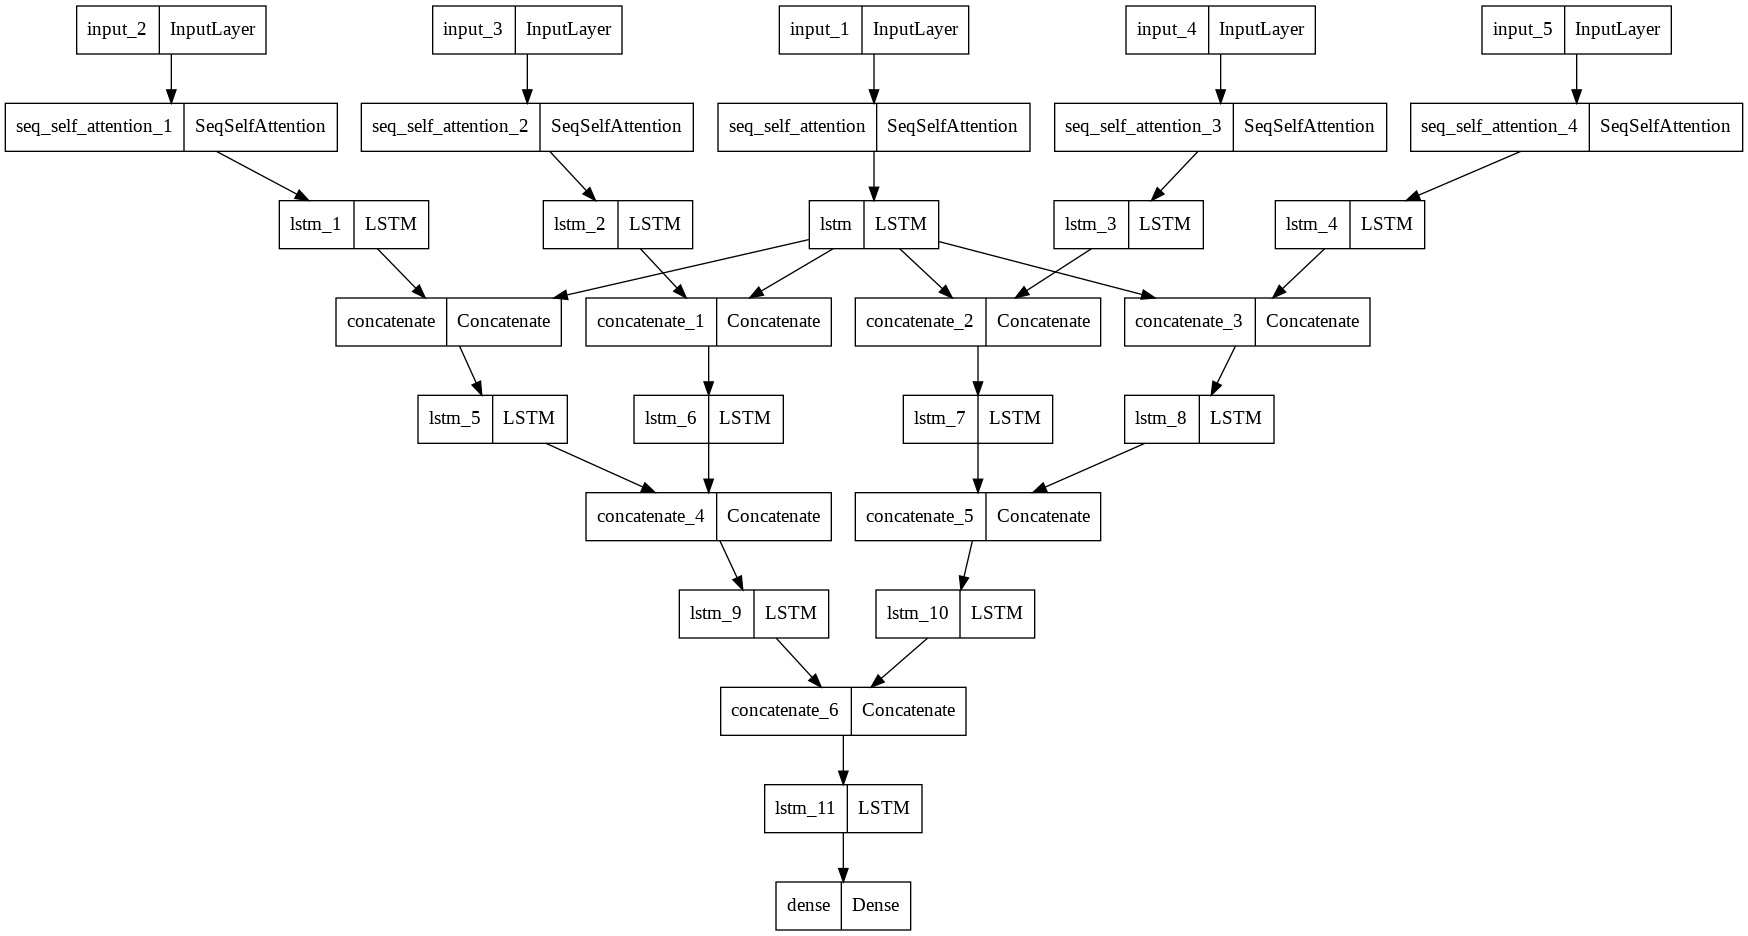

In [13]:
model=create_keras_model()
model.summary()
plot_model(model, to_file='hierarchy-model.png')

#Train, save and evaluate the model

In [14]:
%%time
hist = model.fit([bd_train_valid,rh_train_valid,lh_train_valid,rf_train_valid,lf_train_valid],
          cat_target_train_valid,
          epochs=250,
          validation_split=0.0,
          batch_size=64)

Epoch 1/250
57/57 [==============================] - 43s 387ms/step - loss: 2.9503 - acc: 0.0839
Epoch 2/250
57/57 [==============================] - 22s 391ms/step - loss: 2.8087 - acc: 0.1228
Epoch 3/250
57/57 [==============================] - 23s 395ms/step - loss: 2.7077 - acc: 0.1533
Epoch 4/250
57/57 [==============================] - 22s 394ms/step - loss: 2.6516 - acc: 0.1661
Epoch 5/250
57/57 [==============================] - 22s 393ms/step - loss: 2.5788 - acc: 0.1814
Epoch 6/250
57/57 [==============================] - 22s 393ms/step - loss: 2.5526 - acc: 0.1869
Epoch 7/250
57/57 [==============================] - 22s 394ms/step - loss: 2.5092 - acc: 0.2131
Epoch 8/250
57/57 [==============================] - 22s 394ms/step - loss: 2.5086 - acc: 0.2214
Epoch 9/250
57/57 [==============================] - 23s 395ms/step - loss: 2.4532 - acc: 0.2233
Epoch 10/250
57/57 [==============================] - 22s 394ms/step - loss: 2.4092 - acc: 0.2372
Epoch 11/250
57/57 [=========

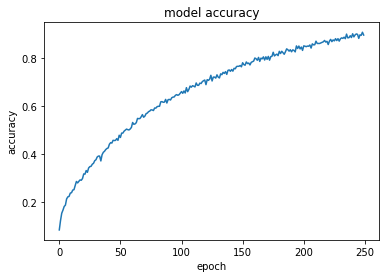

In [15]:
plt.plot(hist.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig('model_acc.png')
plt.show()

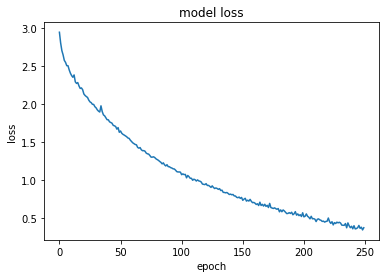

In [16]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('model_loss.png')
plt.show()

In [ ]:
model.save('model_cv')

In [ ]:
!zip -r model_cv.zip model_cv

#Load the trained model and make prediction

In [12]:
!unzip -q model_cv.zip

In [22]:
model = keras.models.load_model('/content/model_cv')

In [23]:
prds = model.predict([bd_test,rh_test,lh_test,rf_test,lf_test],
                     batch_size=8)

pre_labels = np.array([np.argmax(i) for i in prds])

label_test = np.argmax(cat_target_test, axis=1)

test_acc = np.sum(label_test  == pre_labels) / len(pre_labels)

print(f"Test accuracy: {100 * test_acc}%")

Test accuracy: 80.5%


#Visualization of results

In [66]:
true_indexes = np.where(label_test == pre_labels)[0]
false_indexes = np.where(label_test != pre_labels)[0]

In [67]:
random_true_idx = np.random.choice(true_indexes)
random_false_idx = np.random.choice(false_indexes)

In [68]:
visualize(file_number=random_true_idx, verbose=False)#True Prediction

In [69]:
!rm -r *_plot.png

In [79]:
visualize(file_number=random_false_idx, verbose=False)#False Prediction

In [80]:
!rm -r *_plot.png